In [3]:
import numpy as np
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [120]:
sns.set_theme(style='whitegrid')

The Franke function:

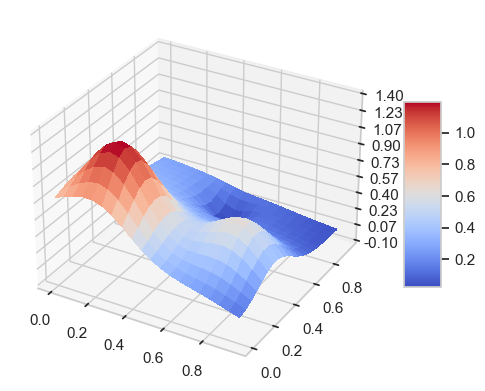

In [121]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Implementing the design matrix:

In [167]:
def Vandermonde_matrix(x: np.ndarray, p: int, no_intercept=True) -> np.ndarray:
    """Sets up a Vandermonde matrix given an input array x and the polynomial degree.
    Optionally, one can include the intercept by setting no_intercept to False."""
    if p == 0: return np.ones((len(x),1))
    Vandermonde: np.ndarray = [x**i for i in range(no_intercept,p+1)]
    return np.hstack(Vandermonde)

### a)

First function for experimentation

In [168]:
np.random.seed(3)
n = 100
# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1) # column vector
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)

In [176]:
p = 5 # highest polynomial degree
N = np.arange(p+1) # for looping and plotting later

MSE_OLS_train, MSE_OLS_test = np.zeros(p), np.zeros(p)
R2_OLS_train, R2_OLS_test = np.zeros(p), np.zeros(p)
beta_values = np.zeros((p+1,p+1))

for i in N:
    # Constructing the design matrix
    X = Vandermonde_matrix(x, i) # degree i, no intercept

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Scaling the data (only centering)
    y_train_mean = np.mean(y_train)
    y_train_centered = y_train - y_train_mean
    
    if i == 0: beta_values[0,0] = y_train_mean; continue # degree 0 case
    
    X_train_mean = np.mean(X_train, axis=0) # 1D array of each column mean
    X_train_centered = X_train - X_train_mean
    X_test_centered = X_test - X_train_mean # centering with training data

    # solving OLS
    beta_OLS = np.linalg.inv(X_train_centered.T @ X_train_centered) @ X_train_centered.T @ y_train_centered
    intercept = y_train_mean - np.dot(X_train_mean, beta_OLS.ravel()) # recovering intercept, !!! something wrong here, see next comment !!!

    y_tilde_OLS = X_train_centered @ beta_OLS + y_train_mean # predictor on training data # y_train_mean is much better than the intercept!!!
    y_predict_OLS = X_test_centered @ beta_OLS + y_train_mean # predictor on test data

    MSE_OLS_train[i-1] = mean_squared_error(y_tilde_OLS, y_train)
    MSE_OLS_test[i-1] = mean_squared_error(y_predict_OLS, y_test)
    R2_OLS_train[i-1] = r2_score(y_tilde_OLS, y_train)
    R2_OLS_test[i-1] = r2_score(y_predict_OLS, y_test)

    beta_values[i,0] = intercept
    beta_values[i,1:i+1] = beta_OLS.T

beta_values

array([[ 6.79023121e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.14192778e-01,  2.71485074e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.28686845e-01,  2.65095032e-01, -3.94513598e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.48955647e-01,  4.66480544e-01, -4.83714139e-02,
        -3.75479296e-02,  0.00000000e+00,  0.00000000e+00],
       [ 8.50932242e-01,  4.66129853e-01, -5.06851398e-02,
        -3.74614945e-02,  3.04539418e-04,  0.00000000e+00],
       [ 8.48187807e-01,  3.69921410e-01, -4.64809288e-02,
         1.19562421e-02, -5.28975905e-04, -4.92238728e-03]])

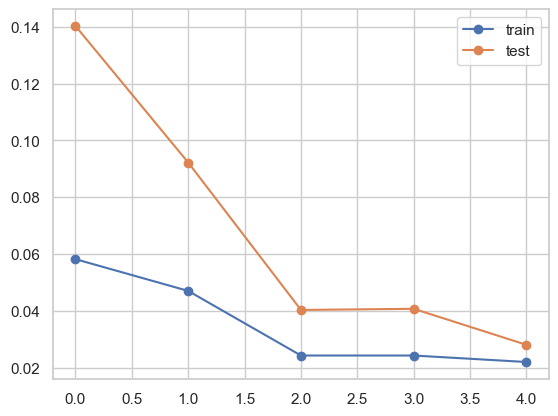

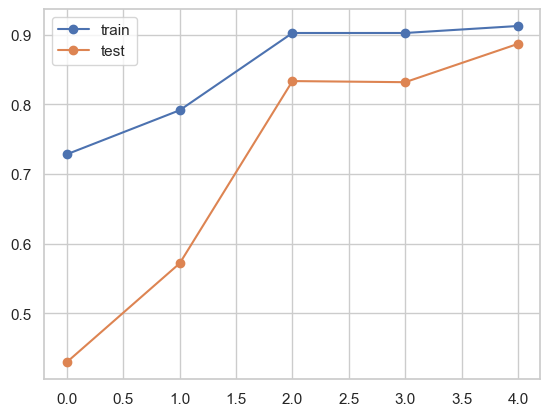

In [174]:
N = np.arange(p)

# Plotting OLS MSE and R2 against complexity
plt.plot(N, MSE_OLS_train, 'o-', label='train')
plt.plot(N, MSE_OLS_test, 'o-', label='test')
plt.legend(); plt.show()

plt.plot(N,R2_OLS_train, 'o-', label='train')
plt.plot(N,R2_OLS_test, 'o-', label='test')
plt.legend(); plt.show()

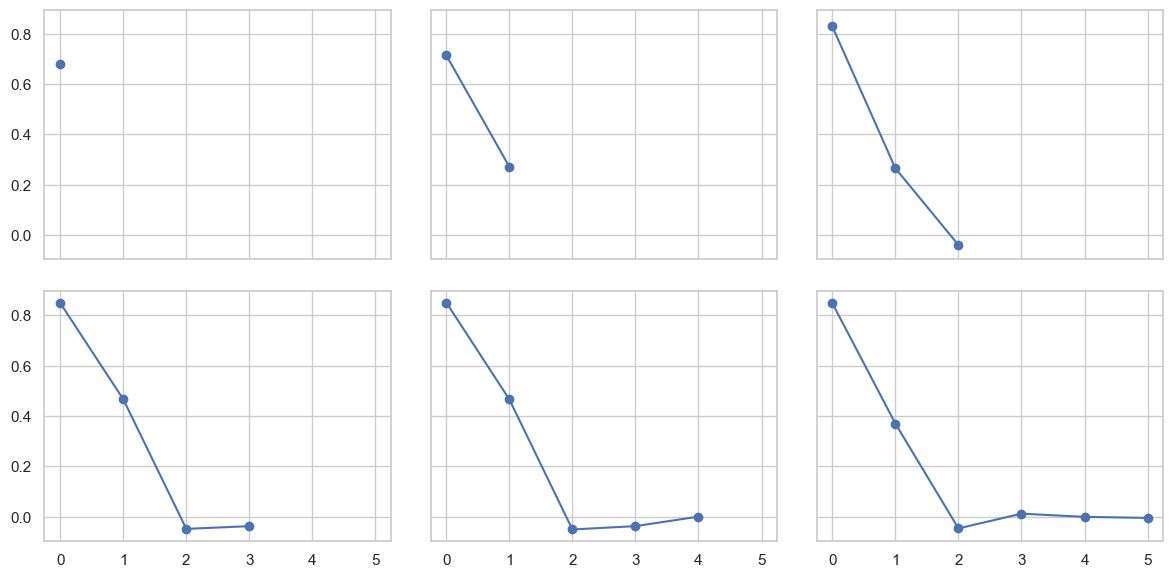

In [178]:
N = np.arange(p+1)

# Plotting beta coefficients
fig, axs = plt.subplots(2,3, figsize=(12, 6), sharex=True, sharey=True); fig.tight_layout()
for row in range(2):
    for col in range(3):
        axs[row, col].plot(N[:3*row + col + 1], beta_values[3*row + col][:3*row + col + 1], 'o-')    
plt.show()

### b)

In [ ]:
p = 6 # highest polynomial degree
N = np.arange(p) # for looping and plotting later

MSE_OLS_train, MSE_OLS_test = np.zeros(p), np.zeros(p)
R2_OLS_train, R2_OLS_test = np.zeros(p), np.zeros(p)
beta_values = np.zeros((p,p))

for i in N:
    # Constructing the design matrix
    X = Vandermonde_matrix(x, i+1) # degree i+1, no intercept

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Scaling the data (only centering)
    X_train_mean = np.mean(X_train, axis=0) # 1D array of each column mean
    X_train_centered = X_train - X_train_mean
    X_test_centered = X_test - X_train_mean # centering with training data

    y_train_mean = np.mean(y_train)
    y_train_centered = y_train - y_train_mean

    # --- Solving OLS
    beta_OLS = np.linalg.inv(X_train_centered.T @ X_train_centered) @ X_train_centered.T @ y_train_centered
    beta_values[i,:i+1] = beta_OLS.T

    y_tilde_OLS = X_train_centered @ beta_OLS + y_train_mean # predictor on training data
    y_predict_OLS = X_test_centered @ beta_OLS + y_train_mean # predictor on test data

    MSE_OLS_train[i], MSE_OLS_test[i] = mean_squared_error(y_tilde_OLS, y_train), mean_squared_error(y_predict_OLS, y_test)
    R2_OLS_train[i], R2_OLS_test[i] = r2_score(y_tilde_OLS, y_train), r2_score(y_predict_OLS, y_test)


In [ ]:
# very similar to a), but with lambdas

p = 6 # highest polynomial degree
N = np.arange(p) # for looping and plotting later

logmin, logmax, l = -4, 2, 6 # logspce start, end, number of lambda values
llambda = np.logspace(logmin, logmax, l)

MSE_Ridge_train, MSE_Ridge_test = np.zeros((p,l)), np.zeros((p,l))
R2_Ridge_train, R2_Ridge_test = np.zeros((p,l)), np.zeros((p,l))
beta_values = np.zeros((p,p))


for i in N:
    # Constructing the design matrix
    X = Vandermonde_matrix(x, i+1) # degree i+1, no intercept

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Scaling the data (only centering)
    X_train_mean = np.mean(X_train, axis=0) # 1D array of each column mean
    X_train_centered = X_train - X_train_mean
    X_test_centered = X_test - X_train_mean # centering with training data

    y_train_mean = np.mean(y_train)
    y_train_centered = y_train - y_train_mean


    # --- Solving Ridge for different hyperparameters
    I = np.eye(i+1,i+1)

    for j in range(l): 
        beta_ridge = np.linalg.inv(X_train_centered.T@X_train_centered + llambda[j]*I) @ X_train_centered.T @ y_train_centered
        beta_values[i,:i+1] = beta_ridge.T
        
        y_tilde_ridge = X_train_centered @ beta_ridge + y_train_mean
        y_predict_ridge = X_test_centered @ beta_ridge + y_train_mean

        # calculating the MSE for each lambda-value
        MSE_Ridge_train[i,j] = mean_squared_error(y_train,y_tilde_ridge)
        MSE_Ridge_test[i,j] = mean_squared_error(y_test,y_predict_ridge)
MSE_Ridge_train


array([[0.05816675, 0.05816675, 0.05816675, 0.05816738, 0.05831627,
        0.07754146],
       [0.04697786, 0.04697786, 0.04697786, 0.04697846, 0.04712043,
        0.06549663],
       [0.02422395, 0.02422395, 0.024224  , 0.02423554, 0.02638883,
        0.07811171],
       [0.02422035, 0.02422035, 0.02422039, 0.02423193, 0.02638238,
        0.07839131],
       [0.02193626, 0.02193626, 0.02193634, 0.02195549, 0.02406352,
        0.03933332],
       [0.02048672, 0.02048672, 0.02048682, 0.02050901, 0.02293165,
        0.0393929 ]])

In [ ]:
beta_values

[[],
 [array([0.27148507])],
 [array([0.26509503]), array([-0.03945136])],
 [array([0.46648054]), array([-0.04837141]), array([-0.03754793])],
 [array([0.46612985]),
  array([-0.05068514]),
  array([-0.03746149]),
  array([0.00030454])]]

### c)

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

Franke function

In [32]:
# Make data.
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)

x = x.ravel()
y = y.ravel()

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

In [33]:
MSE = np.zeros(3)
for ex_p in [5, 10, 15]:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    # we use pipeline to fit our model
    pipeline = make_pipeline(
        PolynomialFeatures(degree=ex_p),
        StandardScaler(),
        Lasso(1e-4))

    pipeline.fit(X,z)
    z_predict = pipeline.predict(X)

    MSE[ex_p//5-1] = mean_squared_error(z_predict, z)

c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+01, tolerance: 8.236e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e+01, tolerance: 8.236e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

In [34]:
MSE

array([0.00753043, 0.00518562, 0.00503276])

In [35]:
x_plot = x.reshape((n, n))
y_plot = y.reshape((n, n))
z_plot = z.reshape((n, n))
z_pred_plot = z_predict.reshape((n, n))

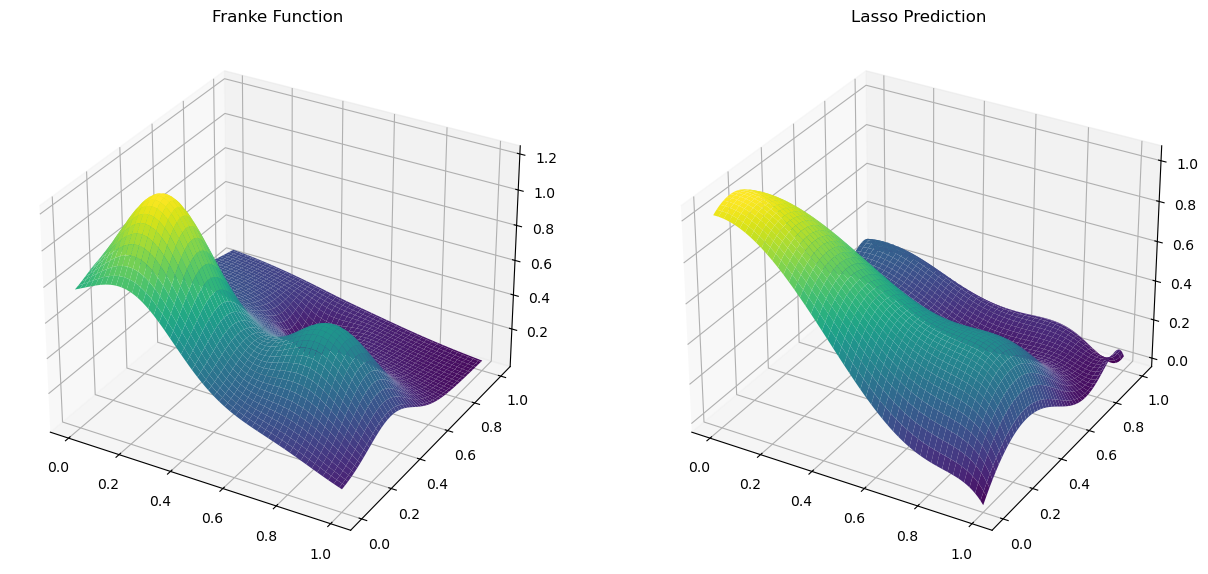

In [36]:
fig = plt.figure(figsize=(12, 6))

# Plotting the Franke function
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('Franke Function')

# Plot the polynomial regression prediction
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_pred_plot, cmap='viridis', edgecolor='none')
ax.set_title('Lasso Prediction')

plt.show()


### Stuff

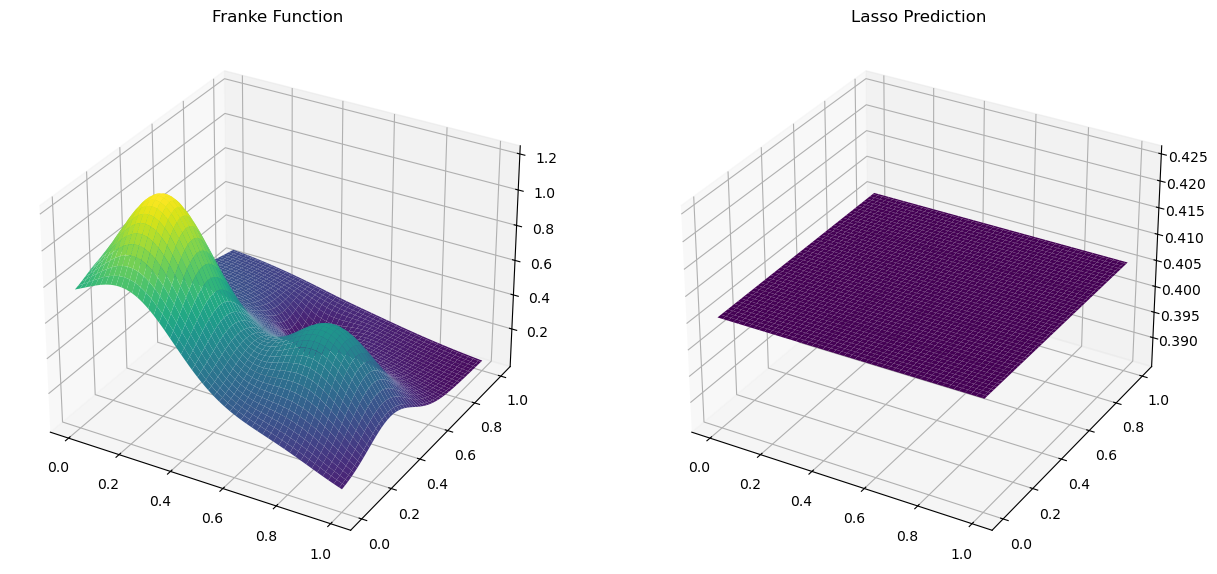

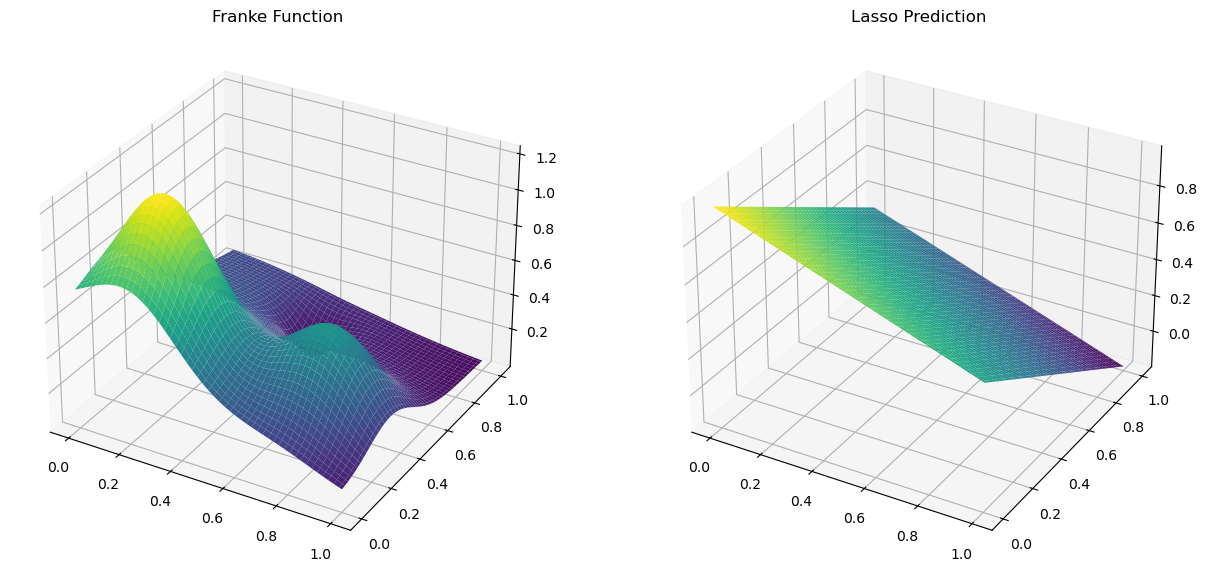

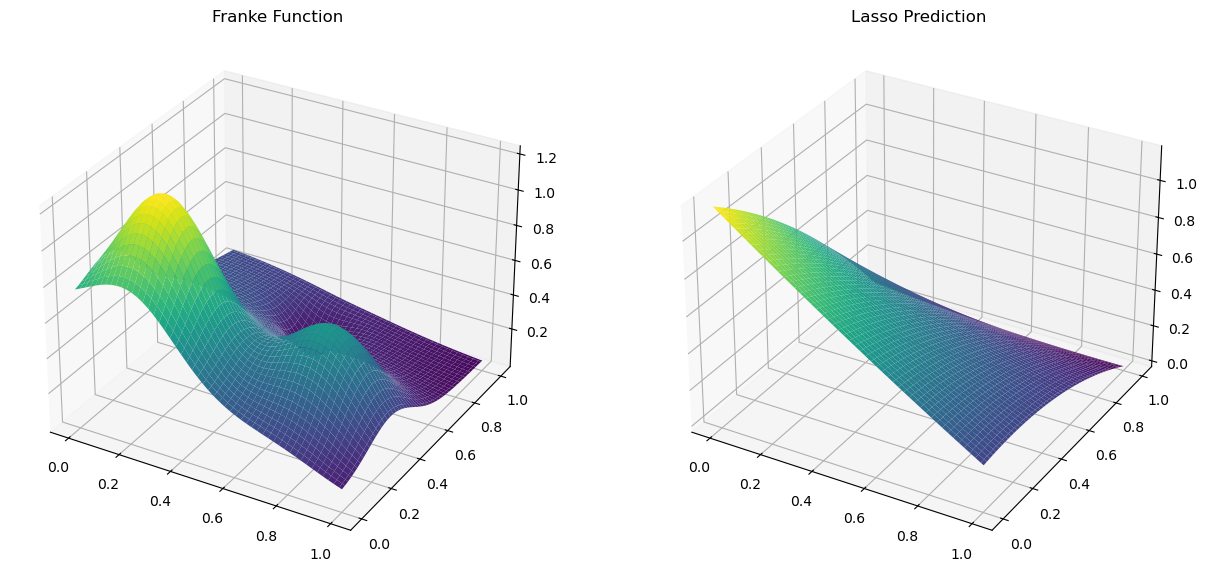

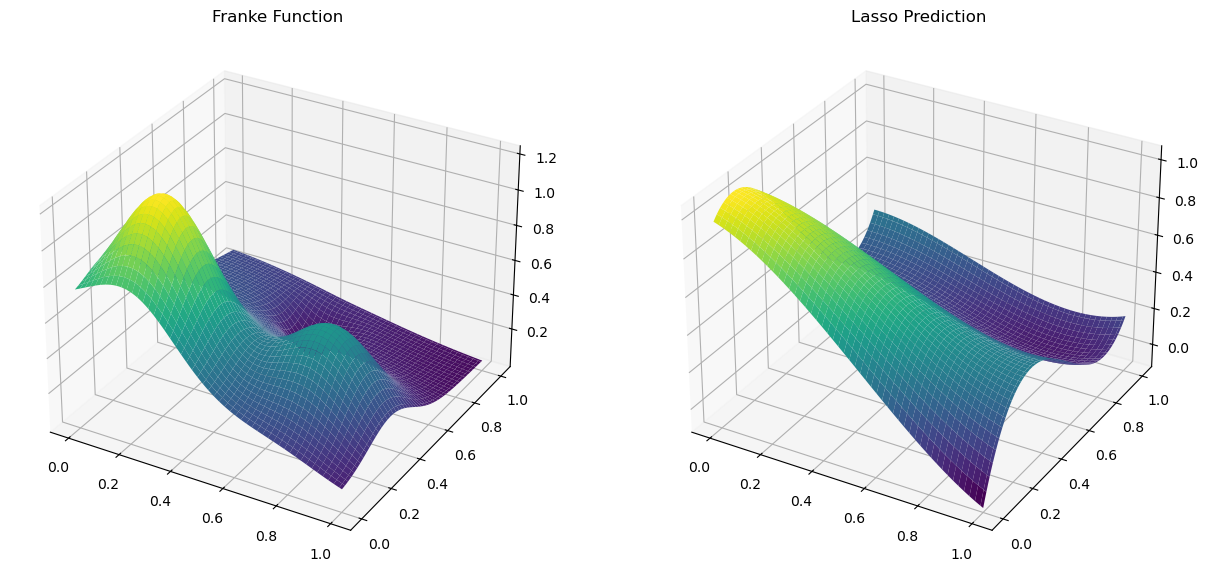

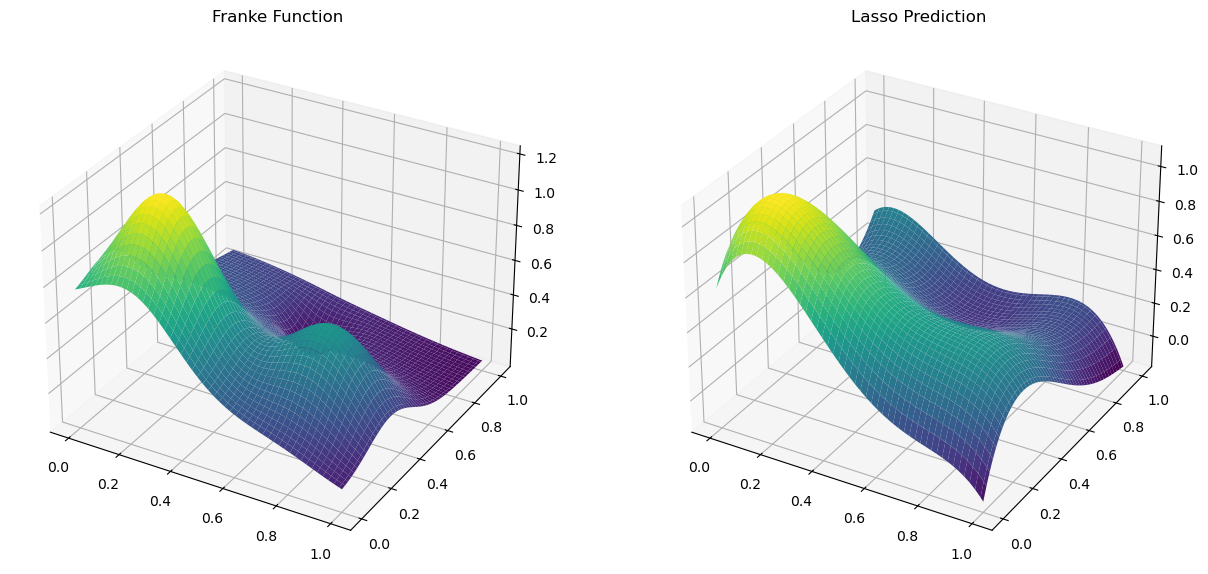

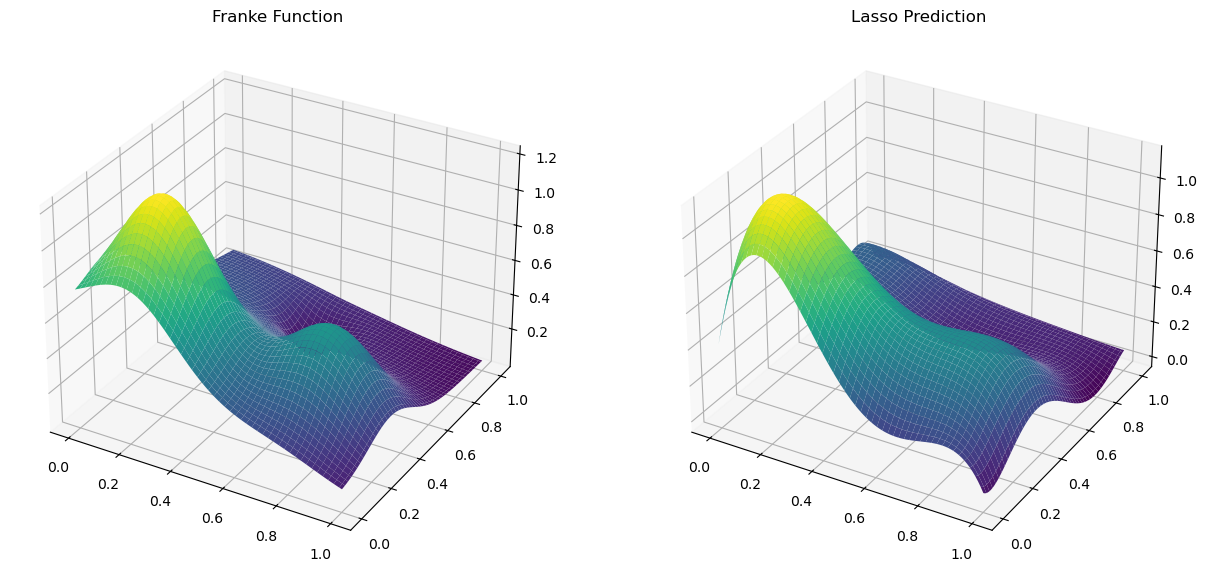

[0.00208129 0.         0.00407544]


In [42]:
# Make data.
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)

x = x.ravel()
y = y.ravel()

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

MSE = np.zeros(3)
for ex_p in [0,1,2,3,4,5]:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    # we use pipeline to fit our model
    pipeline = make_pipeline(
        PolynomialFeatures(degree=ex_p),
        StandardScaler(),
        Lasso(1e-4))

    pipeline.fit(X,z)
    z_predict = pipeline.predict(X)

    MSE[ex_p//5-1] = mean_squared_error(z_predict, z)

    x_plot = x.reshape((n, n))
    y_plot = y.reshape((n, n))
    z_plot = z.reshape((n, n))
    z_pred_plot = z_predict.reshape((n, n))


    fig = plt.figure(figsize=(12, 6))

    # Plotting the Franke function
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
    ax.set_title('Franke Function')

    # Plot the polynomial regression prediction
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(x_plot, y_plot, z_pred_plot, cmap='viridis', edgecolor='none')
    ax.set_title('Lasso Prediction')

    plt.show()

print(MSE)
